In [204]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.gofplots import qqplot
import numpy as np
import scipy as sp
from scipy import stats as st

from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

from sklearn.feature_selection import SelectKBest, mutual_info_classif

import statsmodels.api as sm
from statsmodels.formula.api import ols
import statsmodels as stm

pd.set_option('display.max_columns', None)
#pd.set_option('display.max_rows', None)

plt.rc("font", size=14)

import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

# Synthetic Minority Over-sampling Technique
from imblearn.over_sampling import SMOTE

# Recursive Feature Elimination (RFE)
from sklearn.feature_selection import RFE
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

In [205]:
df = pd.read_excel('../BaseDeDados/Bankloan.xlsx')

In [206]:
df.head(3)

,cod,idade,educacao,t_emprego,t_endereco,renda,divida,divida_cc,outras_div,default
0,1,41,Superior incompleto,18,7,176,10.3,11.359392,5.008608,Yes
1,2,27,Médio incompleto,10,6,31,17.3,1.362202,4.000798,No
2,3,40,Médio incompleto,15,14,55,5.5,0.856075,2.168925,No


In [207]:
# Criando coluna binária
df['default_num'] = np.where(df['default'] == 'Yes', 0, 1)

In [208]:
df.head(3)

,cod,idade,educacao,t_emprego,t_endereco,renda,divida,divida_cc,outras_div,default,default_num
0,1,41,Superior incompleto,18,7,176,10.3,11.359392,5.008608,Yes,0
1,2,27,Médio incompleto,10,6,31,17.3,1.362202,4.000798,No,1
2,3,40,Médio incompleto,15,14,55,5.5,0.856075,2.168925,No,1


In [209]:
# Dummy variables
cat_vars=['educacao']

for var in cat_vars:
    cat_list='var'+'_'+var
    cat_list = pd.get_dummies(df[var], prefix=var)
    df1=df.join(cat_list)
    df=df1
cat_vars=['educacao']
data_vars=df.columns.values.tolist()
to_keep=[i for i in data_vars if i not in cat_vars]

In [210]:
df.head(3)

,cod,idade,educacao,t_emprego,t_endereco,renda,divida,divida_cc,outras_div,default,default_num,educacao_Médio completo,educacao_Médio incompleto,educacao_Pós-graduação,educacao_Superior completo,educacao_Superior incompleto
0,1,41,Superior incompleto,18,7,176,10.3,11.359392,5.008608,Yes,0,False,False,False,False,True
1,2,27,Médio incompleto,10,6,31,17.3,1.362202,4.000798,No,1,False,True,False,False,False
2,3,40,Médio incompleto,15,14,55,5.5,0.856075,2.168925,No,1,False,True,False,False,False


In [211]:
df1=df[to_keep]
df1.columns.values

array(['cod', 'idade', 't_emprego', 't_endereco', 'renda', 'divida',
       'divida_cc', 'outras_div', 'default', 'default_num',
       'educacao_Médio completo', 'educacao_Médio incompleto',
       'educacao_Pós-graduação', 'educacao_Superior completo',
       'educacao_Superior incompleto'], dtype=object)

In [212]:
# Data Frame a ser utilizado com todas as variáveis
df2 = df1

In [213]:
X = df1.loc[:, ['t_emprego','t_endereco','divida_cc']]
y = df1.loc[:, df1.columns == 'default_num']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)

In [214]:
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train, y_train.values.ravel())

LogisticRegression(max_iter=1000)

In [215]:
# Seletor de variável automatico:
selector = SelectKBest(score_func=mutual_info_classif, k='all') # pode trocar 'all' por um número
selector.fit(X_train, y_train['default_num'])

SelectKBest(k='all',
            score_func=<function mutual_info_classif at 0x00000212E8C17F60>)

In [216]:
# Ver os scores
scores = pd.DataFrame({'Feature': X.columns, 'Score': selector.scores_})
print(scores.sort_values(by='Score', ascending=False))

      Feature     Score
0   t_emprego  0.065333
2   divida_cc  0.058588
1  t_endereco  0.040787


In [217]:
# Coeficientes das variáveis
coef = pd.DataFrame({'Feature': X.columns, 'Coefficient': logreg.coef_[0]})
print(coef.sort_values(by='Coefficient', key=abs, ascending=False))

      Feature  Coefficient
2   divida_cc    -0.661122
0   t_emprego     0.213743
1  t_endereco     0.086363


In [218]:
logit_model=sm.Logit(y_train,X_train)
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.438565
         Iterations 7
                         Results: Logit
Model:              Logit            Method:           MLE       
Dependent Variable: default_num      Pseudo R-squared: 0.225     
Date:               2025-04-28 12:01 AIC:              269.1389  
No. Observations:   300              BIC:              280.2503  
Df Model:           2                Log-Likelihood:   -131.57   
Df Residuals:       297              LL-Null:          -169.79   
Converged:          1.0000           LLR p-value:      2.5171e-17
No. Iterations:     7.0000           Scale:            1.0000    
------------------------------------------------------------------
               Coef.   Std.Err.     z     P>|z|    [0.025   0.975]
------------------------------------------------------------------
t_emprego      0.2230    0.0346   6.4489  0.0000   0.1553   0.2908
t_endereco     0.0948    0.0261   3.6263  0.0003   0.0436   0.

In [219]:
y_pred = logreg.predict(X_train)
print('Acuracia do modelo do conjunto de Treino: {:.3f}'.format(logreg.score(X_train, y_train)))

Acuracia do modelo do conjunto de Treino: 0.783


In [220]:
y_train['default_pred'] = y_pred

In [221]:
pd.crosstab(y_train['default_num'], y_train['default_pred'], rownames=['Acesso'], colnames=['Previsto'], margins=True, margins_name='Total')

Previsto,0,1,Total
Acesso,,,
0,24,52,76
1,13,211,224
Total,37,263,300


In [222]:
# Ajuste pratico
y_pred = logreg.predict(X_test)
print('Acuracia do modelo do conjunto de Teste: {:.3f}'.format(logreg.score(X_test, y_test)))

Acuracia do modelo do conjunto de Teste: 0.820


In [248]:
#Valor do intecepto: Beta 0
logreg.intercept_

array([0.12094549])

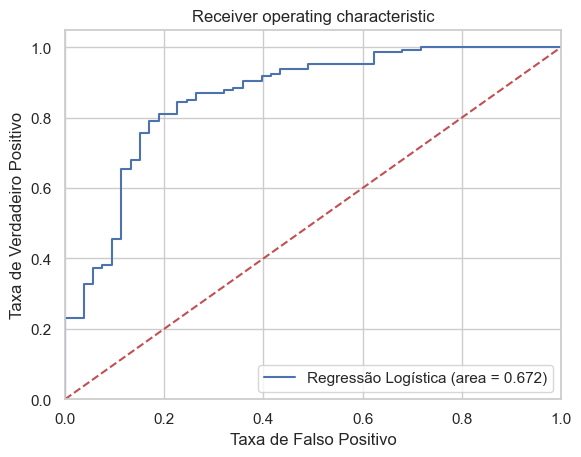

In [223]:
logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Regressão Logística (area = %0.3f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falso Positivo')
plt.ylabel('Taxa de Verdadeiro Positivo')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

In [224]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.36      0.51        53
           1       0.81      0.99      0.89       147

    accuracy                           0.82       200
   macro avg       0.86      0.67      0.70       200
weighted avg       0.84      0.82      0.79       200

